# Tutorial on Bayesian Optimization

**Author:** Aldair E. Gongora

**Date:** February 2, 2021

**Description:** 

In this tutorial, we will be briefly discussing the ideas behind Bayesian optimization (BO) and working through a 1D example problem. The goal of this tutorial is to help you understand the underpinnings of BO and to be able to apply BO to your own problems. To achieve this, we'll first briefly discuss the BO algorithm (I highly recommend this [paper on using BO in materials design](https://arxiv.org/pdf/1506.01349.pdf)). Then, we'll look at how to use BO to optimize a 1D example and describe the process of BO relative to this example problem. Lastly, we'll be discussing how to evaluate the performance of BO algorithms and benchmark three decision policies (expected imporvement (EI), maximum variance (MV), and random search. If you have any additional questions or feedback on the tutorial, feel free to reach out. Thanks!

### Part 1: Overview of Bayesian Optimization

In Bayesian optimization (BO), we are interested in optimizing an unknown function $f(x)$. This objective can be described as solving for $\arg\max(f(x))$ since we're intersted in the design, processing conditions, or parameters $x$ that correspond to the optimum of $f(x)$. BO attempts to address this challenge by iteratively building a ***belief model*** of the unknown function and using a ***decision policy*** to select subsequent experiments. The BO alogrithm is outlined below where we denote an experimental design as $x_i$, its corresponding experimental observation as $y_i$, the dataset with $i$ experimental designs and $i$ observations as  $\{(x_1,y_1),...,(x_{i},y_{i})\}$, and the experimental budget as $N$. 

for $i$ = $1:N$

1. Build belief model $B_i(x)$ using your dataset $\{(x_1,y_1),...,(x_{i},y_{i})\}$
    
2. Use a decision policy $\alpha(x)$ to selected the next experiment $x_{i+1}$
    
3. Conduct the experiment to obtain $y_{i+1}$
    
4. Updated your dataset to reflect the new experimental design and experimental observation $\{(x_1,y_1),...,(x_{i},y_{i}),(x_{i+1},y_{i+1})\}$

end

Now, let's describe each step in the BO algrithm. 

Step 1: The belief model can be thought of as a regression problem where we are fitting a model to the available data. In BO, this model is probabilistic which allows the belief model to capture uncertainty about our beliefs. A popular belief model is a gaussian process. A gaussian process is a nonparametric function that is defined by a mean function and a kernel function. The mean function allows us to capture the general trend or shape we believe the parameter space to have. If we don't have possess enough information to discern the trend or possible shape of the parameter space, we can use a zero-mean mean function, which is often referred to as an uninformative prior. The kernel function captures the correlation between experimental designs in parameter space. This is often described as encoding how much information is captured by an experiment in parameter space. A popular kernel function is the squared exponential gaussian kernel $ k(x,x') = \beta \sum_{i=1}^{d} \exp{\frac{(x-x')^2}{\theta_i}} $.

Step 2: From the belief model $B_i(x)$, we can obtain the mean of the belief model $\mu_i(x)$ and the standard deviation $\sigma_i(x)$. We then use this information to select the next experiment $x_{i+1}$ using a particular decision policy. While several decision policies exist and serve different purposes, a desirable decision policy for optimization attempts to balance exploration and exploitation. This means that the decision policy would ensure to explore parameter space (so we don't omit high performing regions) and also sufficiently exploit high performing regions (so we ensure that we're finding the best experimental design in that region). However, decision policies can also be designed to purely exploratory or purely exploitative depending on the application. To evaluate a decision policy, we use an acquisition function $\alpha(x)$. Below are descriptions on three decision policies and their corresponding acquisition functions. 

* An example of an exploratory decision policy is maximum variance (MV) one where the decision policy selects the next experiment where the variance is the largest. The acquisition function for an MV decision policy is $\arg\max \sigma(x)$.


* An example of a purely exploitative decision poilicy is one where the decision policy selects the next experiment where the mean value is believed to be largest. The acquisition function for an exploitative decision policy is $\arg\max \mu(x)$


* An example of a decision policy that attempts to balance both exploration and exploitation is the expected improvement (EI) decision policy. The EI decision policy seeks to select subsequent experiments based on the likelihood of exceeding previous experimental observations. The acquisition function for the EI decision policy is $\arg\max EI(x)$ where $EI(x) = (\mu_i(x) - f^{*})\Phi(\frac{\mu_i(x)-f^*}{\sigma_I(x)}) + \sigma_i(x) \varphi(\frac{\mu_i(x)-f^*}{\sigma_i(x)})$ where $f^*$ is the max experimental observation in the dataset, $\Phi$ is the cumulative distribution function (CDF), and $\varphi$ is the probability distribution function (PDF). 

Step 3 and 4: With the selected subsequent experimental design $x_{i+1}$, the experimenter or automated experimentation system can then conducted the subsequent experiment to obtain the experimental observation $y_{i+1}$. The dataset can now be updated to $\{(x_1,y_1),...,(x_{i},y_{i}),(x_{i+1},y_{i+1})\}$ and if the experimental budget $N$ has not been exhausted, the process of building the belief model and utilizing the decision policy can be repeated. 

### Part 2: 1 Dimensional Example

We are interested in optimizing the function $f(x)$ which is unknown to us. We can obtain information about $f(x)$ in the form of an experimentation observation $y$ by evaluating the function at a experimental design $x$. In this example, let assume the ground truth function is a 1D sinc function $f(x) = 10sin(10x)$ and we're interested in the domain $x\in[0,1]$. We also have three obsevations in our dataset: $(x_1 = 0.3,y_1 = f(0.3)),(x_2 = 0.6,y_2 = f(0.6)),(x_3 = 0.9,y_3 = f(0.9))$. Let's firstly visualize $f(x)$ and the experimental dataset. 

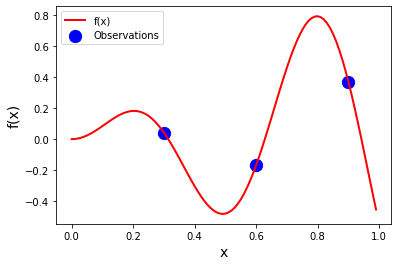

In [1]:
# import relevant libraries 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
import matplotlib 
from matplotlib import pyplot as plt
import GPyOpt
import GPy

# evaluate 1D ground truth function 
c = 10 
x = np.arange(0,1,0.01)
y = x*np.sin(c*x)

# experimental designs and experimental observations 
x_obs = np.array([0.3,0.6,0.9])
y_obs = x_obs*np.sin(c*x_obs)

# plot 1D ground truth function
plt.plot(x,y,linewidth=2,c = 'red')
plt.scatter(x_obs,y_obs,150,color='blue')
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend(['f(x)','Observations'])


#### 1. Building the belief model $B_i(x)$

A belief model $B_i(x)$ can be built using the experimental dataset. In the belief model, we want to capture or represent the experimental datapoints using a probabilistic model. Here, gaussian process regression will be used to build a belief model. To do this, we'll be using the GP toolbox. More details on the toolbox can be found [here](https://sheffieldml.github.io/GPy/).

To build the belief model, we'll be using gaussian process regression with a zero-mean mean function and a squared exponential gaussian kernel which is also referred to as a radial basis function (RBF) kernel. In the GPy implementation, the expression used is $ k(x,x') = \beta \sum_{i=1}^{d} \exp{\frac{(x-x')^2}{\theta_i}} $. 

Here, $\beta$ captures the variance of the belief model prior to fitting to any data. In the example below $2*\sqrt(\beta)$ equal to the range of $f(x)$ of the belief model. This is an important value to keep in mind as it essentially captures the range of values of the unknown function. When setting up the belief model, always keep in mind the range of values of your system. A way to potentially avoid this is to normalize or standardize your experimental observation values.  

Here, a smaller $\theta$ value corresponds to assuming that relatively low correlations exist between experimental designs. A small enough $\theta$ value will result in a spikey belief model. You can achieve this by setting $\theta$ = 1e-5 in the code below. A large $\theta$ value represents high correlations between experimental designs. A $\theta$ value that is too large will result in a linear fit in the example below. You can achieve this by setting $\theta$ = 1000.

An additional parameter to consider is the noise variance. In the [paper](https://arxiv.org/pdf/1506.01349.pdf), this corresponds to $\lambda$ in equation (9) in section 3.5. This value represents the experimental noise you expect in the experimental system.

In this example, we set $\beta$ to 4 and $\theta$ to 1. Since this is a 1-D example, our $\theta$ input is also 1-D. With these values initialized, we can build and visualize $B_i(x)$.  

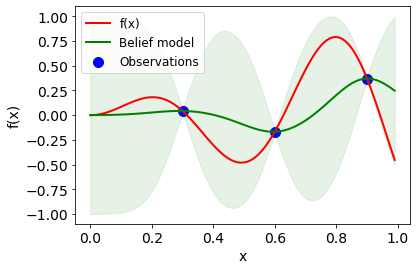

In [2]:
# experimental dataset
x_obs = np.reshape(x_obs,[3,1])
y_obs = np.reshape(y_obs,[3,1])

# initial parameter of the gaussian process 
dim = 1
beta = 1
theta = 0.1 # the smaller, then less correlatin is assumed meaning a very spikey fit.

# the larger, then larger correlation which means that it'll just be a straight line. 

# the kernel function 
k = GPy.kern.RBF(dim,beta,theta,ARD=True)

# building the belief model using Gaussian process regression
m = GPy.models.GPRegression(x_obs,y_obs,k)
m.Gaussian_noise.variance = 1e-3
m.optimize

# prediction using the belief model
x_pred = np.reshape(x,[len(x),1])
y_pred,y_var = m.predict(x_pred,full_cov=False)
y_sd = np.sqrt(y_var)

# plot 1D ground truth function
plt.plot(x,y,color='red',linewidth=2)
plt.scatter(x_obs,y_obs,100,color='blue')
plt.plot(x_pred,y_pred,color='green',linewidth=2)
plt.fill_between(x_pred[:,0],y_pred[:,0]-y_sd[:,0],y_pred[:,0]+y_sd[:,0],alpha=0.1,color='green')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
plt.legend(['f(x)','Belief model','Observations'],fontsize=12)

#### 2. Decision policy:

With the belief model $B_i(x)$ built, we can proceed to selecting the next experiment. Here, we are going to use the expected improvement (EI) decision policy. The acquisition function $\alpha(x)$ corresponding to the EI decision policy is computed for the domain of interest $x \in [0,1]$. Then, the $\arg\max \alpha(x)$ is selected. In this example, it's shown as a red circle in the EI vs $x$ plot. 

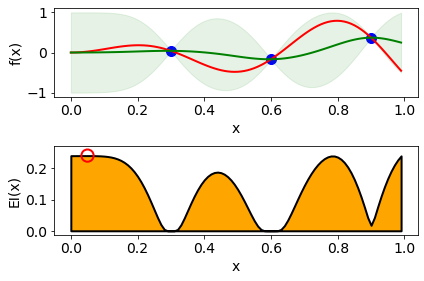

In [3]:
# expected improvement evaluation

f_max = np.max(y_obs)
z = np.divide(y_pred - f_max,y_sd)
phi_pdf = norm.pdf(z)
phi_cdf = norm.cdf(z)

EI = (y_pred-f_max)*phi_cdf + y_sd*phi_pdf

# solving for argmax(EI(x))

argmax_EI = np.argmax(EI)
max_EI = EI[argmax_EI]
argmax = x_pred[argmax_EI,0]
maxval = y_pred[argmax_EI,0]

# visualize EI 

# plot 1D ground truth function
plt.subplot(2,1,1)
plt.plot(x,y,color='red',linewidth=2)
plt.scatter(x_obs,y_obs,100,color='blue')
plt.plot(x_pred,y_pred,color='green',linewidth=2)
plt.fill_between(x_pred[:,0],y_pred[:,0]-y_sd[:,0],y_pred[:,0]+y_sd[:,0],alpha=0.1,color='green')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x', fontsize = 14)
plt.ylabel('f(x)', fontsize = 14)
#plt.legend(['f(x)','Belief model','Observations'],fontsize=12)

# plot EI vs x 
plt.subplot(2,1,2)
plt.fill_between(x_pred[:,0],EI[:,0],facecolor='orange',edgecolor='black',linewidth=2)
plt.scatter(argmax,max_EI,150,marker='o',facecolor='none',edgecolor='red',linewidth=2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('x', fontsize = 14)
plt.ylabel('EI(x)', fontsize = 14)

plt.tight_layout()


#### Step 3 and 4: 

In order to be able to do this iteratively, I've modifed to code to incorporate the ground truth function $f(x)$ and the expected improvement (EI) decision policy as functions. Here, we'll be building the belief model and evaluating the acquisition function to select the next experiment in the learning loop. This will allow us to view how step 1 to 4 is executed in the BO algorithm for a given experiment budget

In the generate plot, we can see that for a belief model trained on $3$ experiments $B_3$, the suggested experiment from the corresponding decision policy evaluation $EI_3$ is shown as a red circle. Moving from left to right with the belief model and the corresponding decision policy evaluation depicted, we observe that the belief model is able find the optimum of $f(x)$. Moreover, we also observe that in this example, the belief model is learns $f(x)$. 


#### Assessing the performance of BO 

To assess the performance of BO in these simulated learning campaigns we can define the performance as $P = \frac{f(\arg\max(B_i))}{f(x)}$. From the $P$ vs $i$ plot, we observe that after 4 experiments we achieve a $P>0.97$ and after 5 experiments we achieve a $P>0.99$

(-0.05, 1.05)

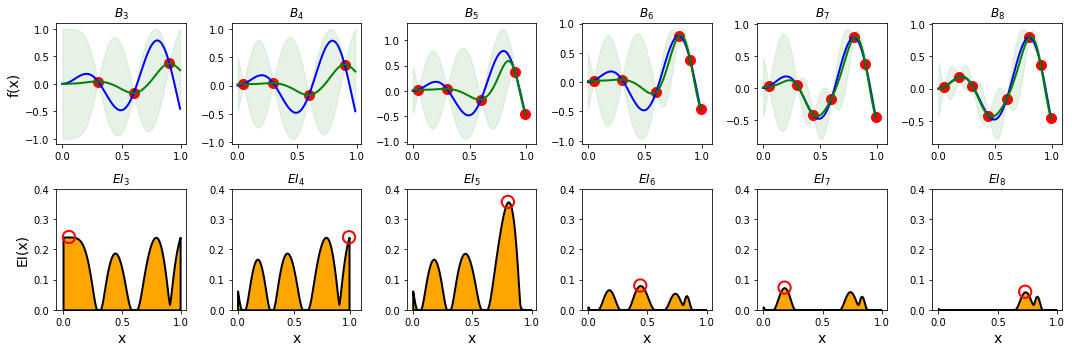

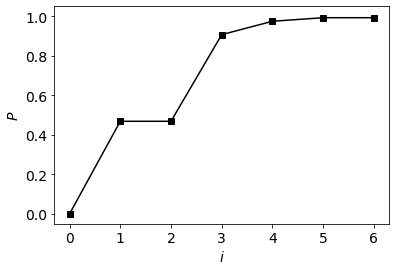

In [9]:
def true_fxn(x):
    # evaluate 1D ground truth function 
    c = 10 
    y = x*np.sin(c*x)
    return y 

def acq_fxn_EI(x,y_obs,y_pred):
    
    # expected improvement preliminaries
    f_max = np.max(y_obs)
    z = np.divide(y_pred - f_max,y_sd)
    phi_pdf = norm.pdf(z)
    phi_cdf = norm.cdf(z)
    
    # expected improvement 
    EI = (y_pred-f_max)*phi_cdf + y_sd*phi_pdf
    
    argmax_EI = np.argmax(EI)
    maxval_EI = EI[argmax_EI]
    argmax = x_pred[argmax_EI,0]
    maxval_y = y_pred[argmax_EI,0]
    
    return argmax,maxval_y,maxval_EI, EI



# true function 
x = np.arange(0,1,0.01)
y = true_fxn(x)
f_max = np.max(y)

# observations 
x_obs = np.array([0.3,0.6,0.9])
y_obs = true_fxn(x_obs)

x_obs = np.reshape(x_obs,[3,1])
y_obs = np.reshape(y_obs,[3,1])


# experiment budget 
N = 6

# subplot id 
plt_id = 1 

# initialize 
P_campaign = np.array([])

fig=plt.figure(figsize=(15, 5))

for i in np.arange(N):
    
    # kernel parameters
    dim = 1
    var = 1
    theta = 0.1
    k = GPy.kern.RBF(dim,var,theta,ARD=True)
    
    # step 1: build belief model
    m = GPy.models.GPRegression(x_obs,y_obs,k)
    m.Gaussian_noise.variance = 1e-3
    m.optimize
    
    # evaluate belief model predictions 
    x_pred = np.reshape(x,[len(x),1])
    y_pred,y_var = m.predict(x_pred,full_cov=False)
    y_sd = np.sqrt(y_var)

    # step 2: use decision policy 
    x_next,y_next,y_next_EI,EI = acq_fxn_EI(x,y_obs,y_pred)
    
    # step 3: run experiment 
    y_next = true_fxn(x_next)
    
    # plot 1D ground truth function
    plt.subplot(2,N,plt_id)
    plt.plot(x,y,color='blue',linewidth=2)
    plt.scatter(x_obs,y_obs,100,color='red')
    plt.plot(x_pred,y_pred,color='green',linewidth=2)
    plt.fill_between(x_pred[:,0],y_pred[:,0]-y_sd[:,0],y_pred[:,0]+y_sd[:,0],alpha=0.1,color='green')
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title('$B'+'_'+str(plt_id+2)+'$')
    
    if plt_id == 1:
        plt.ylabel('f(x)', fontsize = 14)
        
    # plot EI
    plt.subplot(2,N,plt_id+N)
    plt.fill_between(x_pred[:,0],EI[:,0],facecolor='orange',edgecolor='black',linewidth=2)
    plt.scatter(x_next,y_next_EI,150,marker='o',facecolor='none',edgecolor='red',linewidth=2)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('x', fontsize = 14)
    plt.ylim([0,0.4])
    plt.title('$EI'+'_'+str(plt_id+2)+'$')
    
    if plt_id+N == 1+N:
        plt.ylabel('EI(x)', fontsize = 14)
    
    # step 4: update dataset 
    #if i >= 1:
    x_obs = np.vstack([x_obs,x_next])
    y_obs = np.vstack([y_obs,y_next])
    
    # performance 
    P = true_fxn(x[np.argmax(y_pred)])/f_max
    P_campaign = np.hstack([P_campaign,P])
    
    # iterate plt_id
    plt_id += 1
    

    
plt.tight_layout()

plt.figure()
plt.plot(np.arange(0,len(P_campaign)+1),np.hstack([0,P_campaign]),marker='s',linestyle='-',c='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('$i$', fontsize = 14)
plt.ylabel('$P$', fontsize = 14)
plt.ylim([-0.05,1.05])